# Adjacency matrix math

In [1]:
using LinearAlgebra
using Plots
using Statistics
using ColorSchemes

Define exponential decay and geometric decay series functions

In [2]:
# geometric series
g(a,r,n) = a*r.^collect(0:n);

# unit decay series
f(a,n) = g(a,1-a,n)

f (generic function with 1 method)

In [3]:
function adjacency(a00,r,d)
    
    # Initialize the return array
    A = zeros(Float64,d,d)
    
    # Define the ageclass 0 adjacencies row vector to follow a unit decay series, i.e. sums to 1
    a0 = f(a00,d-1)
    a0[d] = a0[d] + (1-sum(a0)) # put the remainder of the finite series into the last bin
    
    # Construct the upper diagonal matrix using a geometric decay of 'r'
    for i = 1:d
        A = A + diagm(i-1 => g(a0[i],r,d-i))
    end
    
    # Fill in the lower diagonal matrix one diagonal at a time
    for i = 1:d-1
        A = A + diagm(-i => g(1-sum(A[i+1,:]),r,d-(i+1)))
    end
    
    return A
end

adjacency (generic function with 1 method)

Calculate the adjacency matrix

In [65]:
A = adjacency(0.6,0.8,10);

Try and match the paper's gradient

In [66]:
dietz = cgrad([:green, :yellow, :orange, :white],[0.1,0.15,0.3,1.0]);

Plot the adjacency matrix

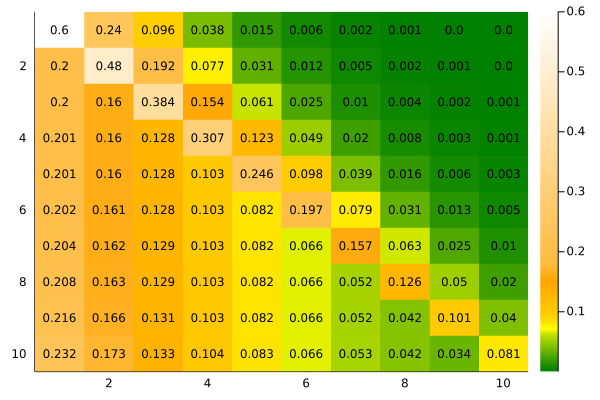

In [67]:
heatmap(1:10, 1:10, A, c = dietz, yflip=true)
fontsize = 8

# Annotate the matrix, make sure to reverse the indexing of text output since y axis is flipped!
ann = [(i,j,text(round(A[j,i],digits=3), fontsize)) for i in 1:10 for j in 1:10]
annotate!(ann)

In [166]:
dietz = cgrad([:green, :yellow, :orange, :white])

## Dietz et all paper

Generate a random array of areas (age x patch)

In [3]:
areas_age_patch = rand(1.0:10.0, (10,20));

Calculate the _fraction of areas for each age class_, $a$.  Site level variable.  Available via fates.

In [8]:
fracarea_age = sum.(eachrow(areas_age_patch./sum(areas_age_patch)));

Generate a random vector of _probability of disturbance initiation_, $p_0$.  Site level variable.  Future parameter value?  Perhaps we could initiate this based on fractional areas?  How about based on the fraction of patches that meet the ignition threshold?

In [5]:
p_0 = rand(10);

Calculate the _initial disturbance area_, $I_1$.  I think this is actually initial disturbance area _fraction_.

In [6]:
I_1 = p_0.*fracarea_age;

Generate an *initial adjacency matrix*, $A_0$.  Right now this is random; make this a geometric decay distribution.  We initially were thinking about setting this based on the age/area fraction for the site.  Perhaps it's simpler to just use a 'standard' initialization based on the expected decay and let the dynamics update it over time?

In [10]:
A_0 = rand(Float64,(10,10));

Set a scalar parameter for a simple *probability of spread across age class*, $p_s$

In [11]:
p_s = 0.1

0.1

Calculate *probability of distribution spread to h patches*, $I$. This is a site-level variable.

In [12]:
I = Array{Float64}(undef,(10,10))
for h = 1:10
    I[h,:] = ((p_s*A_0).^h)*I_1
end

Calculate *overall disturbance rate*, $D$.  This is a site-level variable.

In [14]:
D = sum.(eachrow(I));

Calculate *size distribution*, $p(h)$

In [ ]:
function p(h,I)
    
end

## Initial explorations

Generate a random array of patches areas.  We'll say that the dimensions are patch age x patch 'number'.  There may not be an equivalent number of patches for each age bin (row) in reality.  The maximum number of age rows would be defined by `nlevage`.

In [1]:
areas = rand(1.0:10.0, (3,5))

3×5 Array{Float64,2}:
 5.0  9.0  3.0  4.0  4.0
 2.0  9.0  5.0  9.0  9.0
 8.0  7.0  7.0  4.0  2.0

Calculate the total area in each given patch age bin.  This is equivalent to `ed_site_type%area_by_age` (which doesn't appear to have a direct history variable output).

In [5]:
area_age = sum(areas, dims=2)
# area_age1 = sum.(eachrow(areas))

3×1 Array{Float64,2}:
 25.0
 34.0
 28.0

Calulcate the total patch area for the given site.  This is equivalent to the history variable `FATES_PATCHAREA_AP`.

In [6]:
area_tot = sum(areas)

87.0

Calculate the patch area fraction within the age bin its associated with.  Confirm that the values sum to unity.

In [7]:
# I'm pretty sure Julia has a way to easily broadcast this in one line instead of using a for loop.  Or maybe use a map?
agefrac = Array{Float64}(undef,size(areas))
for i = 1:size(areas)[1]
    agefrac[i,:] = (areas[i,:].*inv(area_age[i]))'
    println(sum(agefrac[i,:]))
end
# inv.(area_age).*collect(eachcol(areas))' # eachcol will create iterator over columns

1.0
1.0
1.0


In [8]:
agefrac

3×5 Array{Float64,2}:
 0.2        0.36      0.12      0.16      0.16
 0.0588235  0.264706  0.147059  0.264706  0.264706
 0.285714   0.25      0.25      0.142857  0.0714286

***How do we use the agefrac to determine a value for self-similar adjacency?***

In [9]:
# Individual fraction of the total area for a given patch
totfrac = areas.*inv.(area_tot)

3×5 Array{Float64,2}:
 0.0574713  0.103448   0.0344828  0.045977  0.045977
 0.0229885  0.103448   0.0574713  0.103448  0.103448
 0.091954   0.0804598  0.0804598  0.045977  0.0229885

***How do we use the totfrac to determine a value for non-similar adjacency?***

In [10]:
# The fraction of the total area for a given patch age
sum(totfrac,dims=2)

3×1 Array{Float64,2}:
 0.28735632183908044
 0.3908045977011494
 0.32183908045977017

In [11]:
# The fraction of the total area for a given patch age
sum(sum(totfrac,dims=2))

1.0

Since the size of patches varies, we will need to determine variance in the sizes

In [13]:
findmin(areas)

(2.0, CartesianIndex(2, 1))

In [14]:
findmax(areas)

(9.0, CartesianIndex(1, 2))

In [18]:
using Statistics

In [19]:
mean(areas[1,:])

5.0

In [23]:
areas

3×5 Array{Float64,2}:
 5.0  9.0  3.0  4.0  4.0
 2.0  9.0  5.0  9.0  9.0
 8.0  7.0  7.0  4.0  2.0